In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('Data/dataset_mood_smartphone.csv')

In [7]:
print(data.size)
data.head()

1884560


,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [15]:
print("There are {} users in this dataset".format(len(data["id"].unique())))
print("Tere are {} variables in this dataset and these variables are {}".format(len(data["variable"].unique()), data["variable"].unique()))

There are 27 users in this dataset
Tere are 19 variables in this dataset and these variables are ['mood' 'circumplex.arousal' 'circumplex.valence' 'activity' 'screen'
 'call' 'sms' 'appCat.builtin' 'appCat.communication'
 'appCat.entertainment' 'appCat.finance' 'appCat.game' 'appCat.office'
 'appCat.other' 'appCat.social' 'appCat.travel' 'appCat.unknown'
 'appCat.utilities' 'appCat.weather']


In [23]:
users = data["id"].unique()
average_num_of_timesteps = np.mean([len(data[data["id"]==user]) for user in users])
print("The average num of timesteps per user is {:.6}".format(average_num_of_timesteps))


The average num of timesteps per user is 13959.7


Average mood is 6.993 with std of 1.033


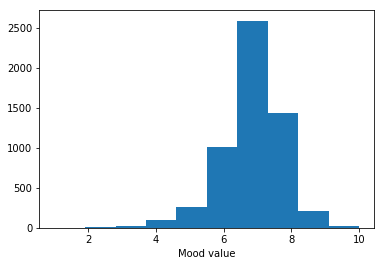

In [34]:
mood_values = data[data["variable"]=="mood"]["value"]
print("Average mood is {:.4} with std of {:.4}".format(np.mean(mood_values), np.std(mood_values)))
plt.hist(mood_values)
plt.xlabel("Mood value")
plt.show()

Average mood per user is 6.995 with std of 0.377


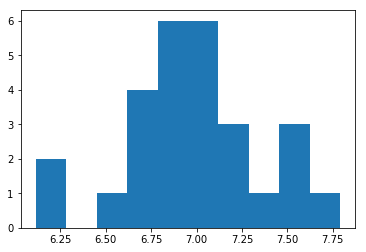

In [102]:
mood_values_per_user = data[data["variable"]=="mood"].groupby(by="id")['value'].mean()
print("Average mood per user is {:.4} with std of {:.4}".format(np.mean(mood_values_per_user), np.std(mood_values_per_user)))
plt.hist(mood_values_per_user)
plt.show()

In [97]:
#helper function to compare two dates

def slice(datum, x = 10):
    return datum[:x]

def get_date_data_frame(data):
    return pd.DataFrame(list(map(slice , data["time"])))
def compare_two_dates(date1, date2):
   
    if (date1[:4])>(date2[:4]):
        return date1
    elif (date1[:4])<(date2[:4]):
        return date2
    elif (date1[5:7])>(date2[5:7]):
            return date1
    elif (date1[5:7])<(date2[5:7]):
        return date2
    elif (date1[8:])>(date2[8:]):
        return date1
    elif (date1[8:])<(date2[8:]):
        return date2
    else: 
        return "same"
dates = get_date(data)[:2]
bigger_date = compare_two_dates(dates.iloc(0)[0][0], dates.iloc(1)[0][0])
print(bigger_date)

#https://stackoverflow.com/questions/22798934/pandas-long-to-wide-reshape-by-two-variables

same


In [113]:
data["dates"] = get_date_data_frame(data)
data[data["variable"]=="mood"].groupby(by="dates")['value'].mean()

dates
2014-02-26    6.250000
2014-02-27    6.333333
2014-03-04    7.000000
2014-03-05    7.166667
2014-03-06    7.222222
2014-03-07    7.444444
2014-03-08    7.300000
2014-03-09    7.200000
2014-03-10    7.000000
2014-03-11    6.400000
2014-03-12    6.700000
2014-03-13    7.083333
2014-03-14    7.434783
2014-03-15    6.461538
2014-03-16    6.461538
2014-03-17    6.379310
2014-03-18    7.137931
2014-03-19    7.000000
2014-03-20    6.605263
2014-03-21    6.885246
2014-03-22    6.746479
2014-03-23    6.987342
2014-03-24    6.753247
2014-03-25    6.831325
2014-03-26    6.916667
2014-03-27    6.897727
2014-03-28    7.090909
2014-03-29    7.433333
2014-03-30    6.988372
2014-03-31    6.977778
                ...   
2014-05-10    7.264706
2014-05-11    6.794118
2014-05-12    7.029412
2014-05-13    7.115385
2014-05-14    6.666667
2014-05-15    6.421053
2014-05-16    7.133333
2014-05-17    7.071429
2014-05-18    6.800000
2014-05-19    7.000000
2014-05-20    7.000000
2014-05-21    6.375000
2014-